### This script shows the **RICE PANICLE IMAGE PROCESSING PIPELINE**.

In [1]:
# Import necessary module
import sys
sys.path.append('..')
from image_processor.RicePanicle import RicePanicle
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Thinning requires a binary image like this

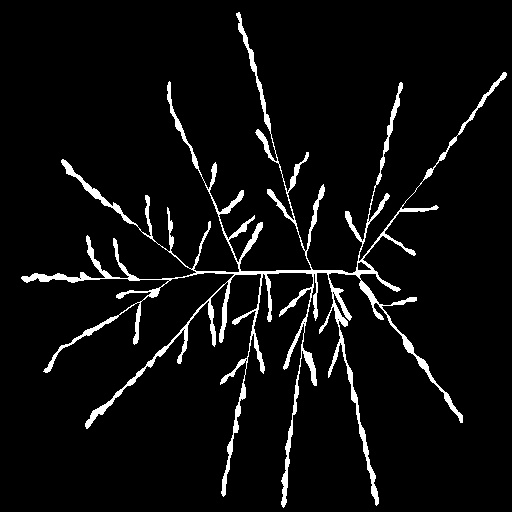

In [2]:
# THINNING
binary_path = "../../crack_segmentation/transfer-learning-results/run_2/DEEPCRACK/13_2_1_1_1_DSC01478.png"
binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)

In [3]:
print(np.unique(binary_img, return_counts=True))

(array([  0, 255], dtype=uint8), array([237930,  24214], dtype=int64))


In [4]:
skeleton_img = RicePanicle.Thinning.zhang_suen(binary_img)

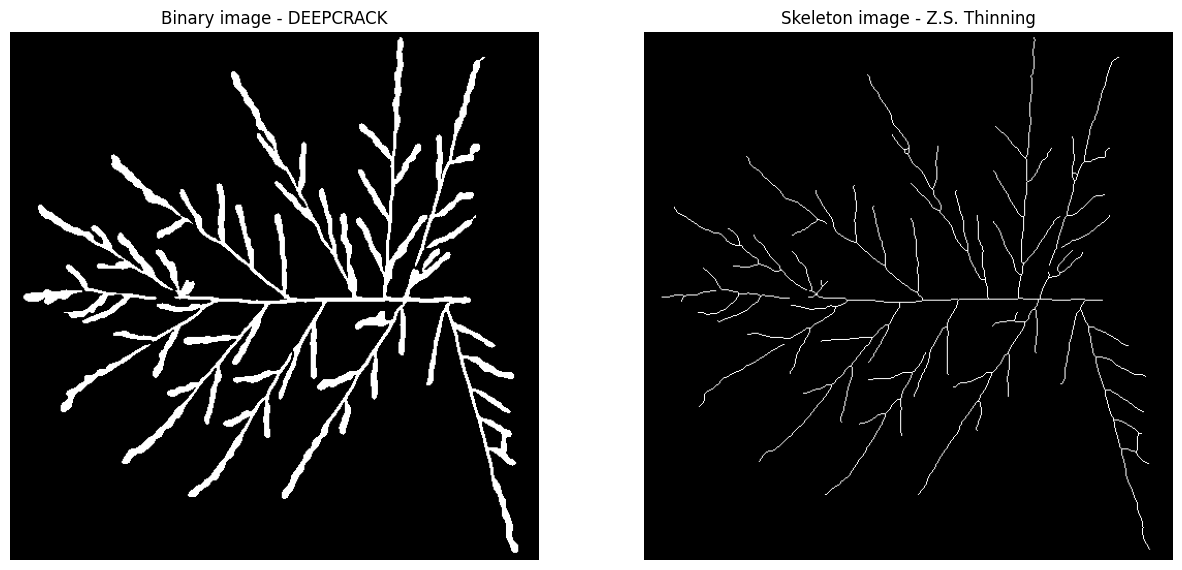

In [5]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.imshow(binary_img, cmap='gray')
ax1.axis('off')
ax1.set_title("Binary image - DEEPCRACK")

ax2.imshow(skeleton_img, cmap='gray')
ax2.axis('off')
ax2.set_title("Skeleton image - Z.S. Thinning")

plt.show()

In [6]:
# CLUSTERING requires a skeleton image. 
junction_img, y_pred = RicePanicle.Clustering.crossing_number(skeleton_img, return_pred_=True)

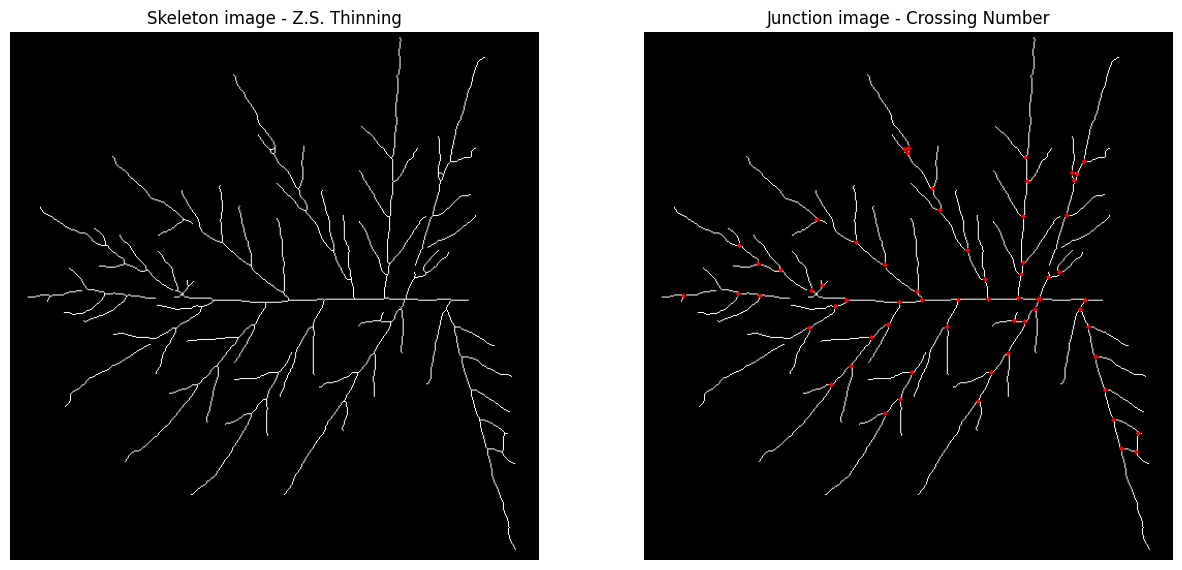

In [7]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.imshow(skeleton_img, cmap='gray')
ax1.axis('off')
ax1.set_title("Skeleton image - Z.S. Thinning")

ax2.imshow(junction_img, cmap='gray')
ax2.axis('off')
ax2.set_title("Junction image - Crossing Number")

plt.show()

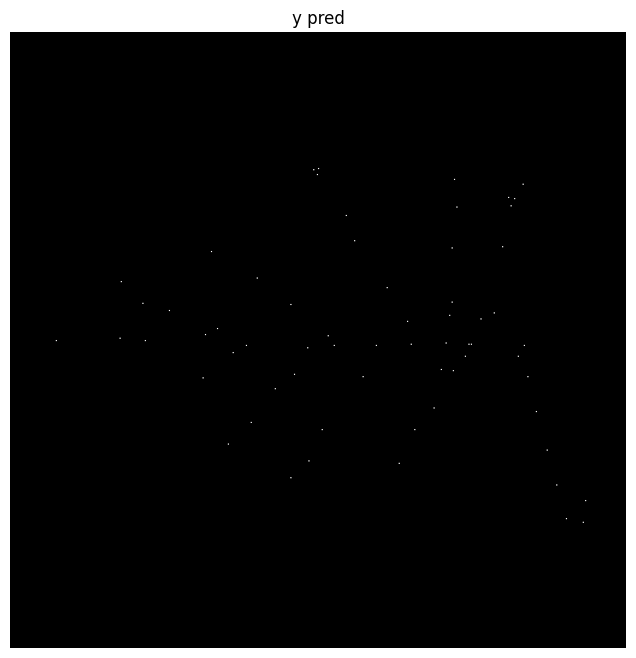

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(y_pred, cmap='gray')
plt.axis('off')
plt.title("y pred")
plt.show()

#### EVALUATION requires y_true -> true junction and y_pred -> predicted junction


In [9]:
# Let's create y_true
from utils.load_ricepr import load_ricepr, resize_xy, generate_y_true

ricepr_path = "../../data/original_ricepr/O. sativa/13_2_1_1_1_DSC01478.ricepr"
junction_xy = load_ricepr(ricepr_path)  # original junction coordinates

In [10]:
# We have to convert in to the size of (512, 512) for consistency
junction_xy_resized = resize_xy(ricepr_path, dst_size=(512, 512))

In [11]:
x_ = []
y_ = []
for key in junction_xy_resized:
    for x, y in junction_xy_resized[key]:
        x_.append(x)
        y_.append(y)

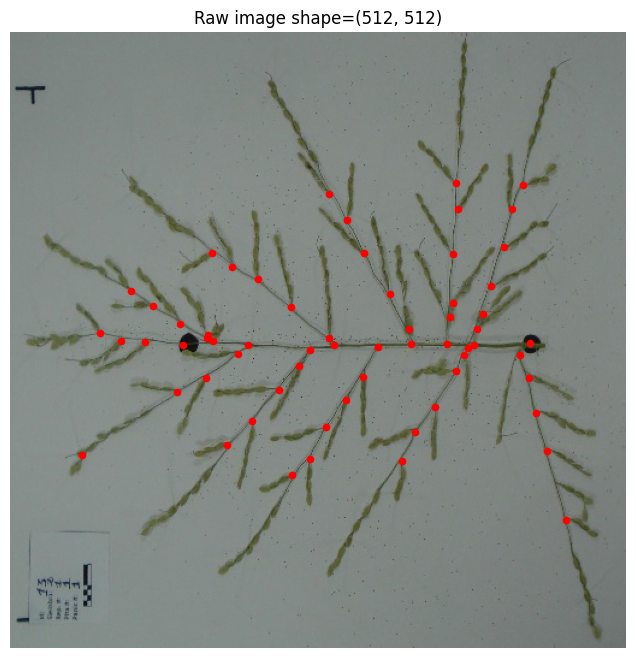

In [12]:
# Visualization
raw_img_512 = plt.imread("../../images/raw_images_512/O. sativa/13_2_1_1_1_DSC01478.jpg")
plt.figure(figsize=(8, 8))
plt.imshow(raw_img_512)
plt.scatter(x_, y_, s=20, c='r')
plt.axis('off')
plt.title("Raw image shape=(512, 512)")
plt.show()

In [13]:
y_true = generate_y_true(junction_xy_resized)

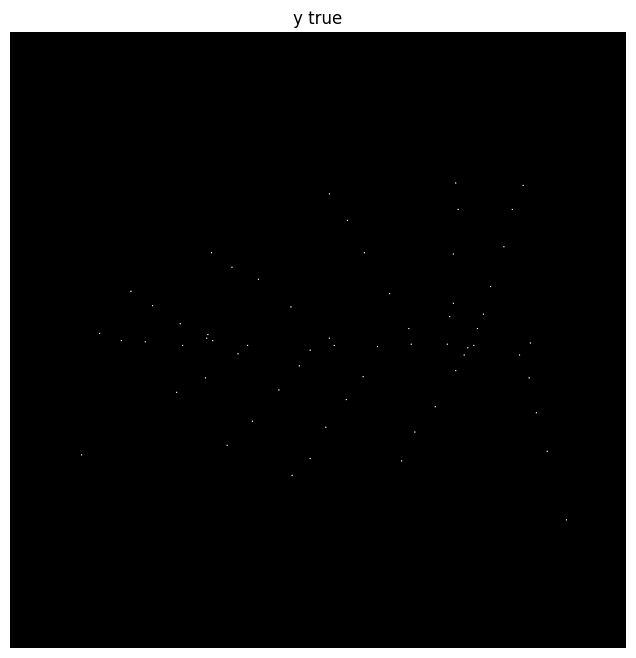

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(y_true, cmap='gray')
plt.axis('off')
plt.title("y true")
plt.show()

In [15]:
f1, pr, rc = RicePanicle.Evaluation.f1_score(y_true, y_pred, _return_metrics=True)
print(f"f1: {f1}, precision: {pr}, recall: {rc}")

f1: 0.6299212598425197, precision: 0.625, recall: 0.6349206349206349
